In [2]:
import pandas as pd
import numpy as np
import string
import spacy
import nltk
import gensim
import matplotlib.pyplot as plt
import re

from gensim.models import LdaMulticore
from gensim.corpora import Dictionary

In [76]:
df = pd.read_csv('../data/raw/database.csv', encoding='latin', index_col=[0])

df.head()

,Fecha Extraccion,Titulo,Fecha Publicacion,Tema,URL,Imagen,Empresa,Fuente,Resumen,Autor,Contenido,RelNewsUrls,Tags
0,2023-02-03 10:58:56,El sube y baja del dÃÂÃÂ³lar: las razones t...,03/02/2023,BOLSAS,https://www.larepublica.co/finanzas/sube-y-baj...,https://img.lalr.co/cms/2023/02/03075229/dolar...,ecopetrol,La RepÃÂÃÂºblica,La divisa estadounidense comenzÃÂÃÂ³ subien...,KAREN VALENTINA MORA AGUILAR,El movimiento del dÃÂÃÂ³lar desde semanas a...,['https://www.larepublica.co/finanzas/precios-...,NaN
1,2023-02-03 10:58:56,Ecopetrol evalÃÂÃÂºa bono ligado a la suste...,01/02/2023,BOLSAS,https://www.larepublica.co/finanzas/ecopetrol-...,"data:image/svg+xml,%3Csvg xmlns='http://www.w3...",ecopetrol,La RepÃÂÃÂºblica,Ecopetrol emitiÃÂÃÂ³ el mes pasado US$2.000...,BLOOMBERG,"Ecopetrol S.A., la petrolera estatal colombian...",['https://www.larepublica.co/empresas/ecopetro...,NaN
2,2023-02-03 10:58:56,"Bancolombia y Ecopetrol, las acciones que mÃÂ...",31/01/2023,BOLSAS,https://www.larepublica.co/finanzas/acciones-d...,"data:image/svg+xml,%3Csvg xmlns='http://www.w3...",ecopetrol,La RepÃÂÃÂºblica,El Msci Colcap presentÃÂÃÂ³ una contracciÃ...,SOFÃÂÃÂA SOLÃÂÃÂRZANO CÃÂÃÂRDENAS,"Este martes, el mercado cerrÃÂÃÂ³ con el Ã...",['https://www.larepublica.co/empresas/ecopetro...,NaN
3,2023-02-03 10:58:57,Ecopetrol anuncia los resultados de la oferta ...,31/01/2023,ENERGÃÂÃÂA,https://www.larepublica.co/empresas/ecopetrol-...,"data:image/svg+xml,%3Csvg xmlns='http://www.w3...",ecopetrol,La RepÃÂÃÂºblica,"SegÃÂÃÂºn el agente depositario, hasta ayer...",NATHALIA VARGAS,Ecopetrol anunciÃÂÃÂ³ los resultados de la ...,['https://www.larepublica.co/empresas/ecopetro...,NaN
4,2023-02-03 10:58:57,La fatal arrogancia del petrismo,31/01/2023,ANALISTAS,https://www.larepublica.co/analisis/andres-fel...,"data:image/svg+xml,%3Csvg xmlns='http://www.w3...",ecopetrol,La RepÃÂÃÂºblica,NaN,SIN AUTOR,No existe un tema para el cual el presidente P...,[],NaN


In [79]:
df['Fecha Publicacion'] = pd.to_datetime(df['Fecha Publicacion'])

C:\Users\andres.ospina\AppData\Local\Temp\ipykernel_25244\2718489030.py:1: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



In [81]:
df['Fecha Publicacion'] = df['Fecha Publicacion'].dt.strftime('%d/%m/%Y')

In [ ]:
df.to_csv('../data/raw/database.csv', encoding='latin-1')

In [10]:
# Eliminar filas sin información en la columna Contenido
df = df.drop(df[df['Contenido'] == "SIN PARRAFOS"].index).reset_index(drop=True)
df = df.drop(df[df['Contenido'].isna()].index).reset_index(drop=True)

### Preprocesamiento

https://towardsdatascience.com/preprocessing-text-data-using-python-576206753c28

Teniendo en cuenta que se esta trabajando con texto en español hay una serie de pasos que no son necesarios:

1. Expandir contracciones.
2. Detectar el idioma.

In [11]:
columna = 'Contenido'

In [12]:
# Descargar modelos 
spacy.cli.download('es_core_news_lg')
es = spacy.load('es_core_news_lg')

✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')


In [13]:
df[f'{columna} procesado'] = df[columna].str.lower()
# Tokenización
df[f'{columna} procesado'] = df[columna].apply(
    lambda x: [token for token in es(x)])
# Normalización (minuscula, tamaño > 3 y solo letras)
df[f'{columna} procesado'] = df[f'{columna} procesado'].apply(
    lambda x: [token for token in x if len(token) > 3 and token.is_alpha])
# Remover stopwords (combinación de contexto y spacy).
# Convertir Token a str
with open('sw_es.txt', 'r', encoding='utf-8') as file:
    stop_words_contexto = {line.split(None, 1)[0] for line in file}
es.Defaults.stop_words |= stop_words_contexto
df[f'{columna} procesado'] = df[f'{columna} procesado'].apply(
    lambda x: [token for token in x if not token.is_stop])

2.3 Radicalización (stemming)

In [14]:
stemmer = nltk.SnowballStemmer('spanish')
df[f'{columna} radicalizado'] = df[f'{columna} procesado'].apply(
    lambda x: [stemmer.stem(token.orth_) for token in x])

2.4 Lemmatization

In [15]:
df[f'{columna} lemmatizado'] = df[f'{columna} procesado'].apply(
    lambda x: {token.orth_: token.lemma_ for token in x})

##### Feature engineering

In [16]:
# Entidades
df['Entidades'] = df['Contenido'].apply(lambda x: {ent.text: ent.label_ for ent in es(x).ents})

In [17]:
df["Contenido segmentado"] = df["Contenido"].str.lower().apply(lambda x: [segment for segment in es(x).sents])

In [18]:
df_ecopetrol = df[df['Empresa'] == "ecopetrol"]
tokens_ecopetrol = [token for lst in df_ecopetrol[f'{columna} procesado'] for token in lst]
words_ecopetrol = [token.orth_ for token in tokens_ecopetrol]

In [19]:
frequency = nltk.FreqDist(words_ecopetrol)
frequency.most_common(20)

[('Ecopetrol', 444),
 ('empresa', 136),
 ('Gobierno', 114),
 ('acciones', 109),
 ('presidente', 106),
 ('petrolera', 95),
 ('ciento', 89),
 ('billones', 86),
 ('Colombia', 82),
 ('pesos', 80),
 ('Petro', 70),
 ('millones', 69),
 ('gobierno', 59),
 ('venta', 57),
 ('negocio', 55),
 ('junta', 52),
 ('Silla', 52),
 ('Felipe', 51),
 ('mercado', 50),
 ('empresas', 50)]

In [20]:
entidades = []
for i in df_ecopetrol['Entidades']:
    entidades += i.keys()

In [21]:
frequency_ent = nltk.FreqDist(entidades)
frequency_ent.most_common(20)

[('Ecopetrol', 71),
 ('Felipe', 35),
 ('Colombia', 25),
 ('Gobierno', 24),
 ('Ecopetrol.', 16),
 ('ISA', 15),
 ('Estado', 14),
 ('Junta Directiva', 14),
 ('AdemÃ\x83Â¡s', 14),
 ('La Silla', 13),
 ('Gustavo Petro', 12),
 ('Bolsa de Valores de Colombia', 12),
 ('Petro', 11),
 ('de Colombia', 11),
 ('mÃ\x83Â¡s', 10),
 ('caÃ\x83Â\xadda', 10),
 ('Silla', 9),
 ('lÃ\x83Â\xadnea', 8),
 ('pÃ\x83Âºblicos', 7),
 ('Brasil', 7)]

In [50]:
ecopetrol_bigrams = list(nltk.ngrams(words_ecopetrol, 1))
fdist_bigrams = nltk.FreqDist(ecopetrol_bigrams)
ensayo = fdist_bigrams.most_common(20)

In [75]:
fdist_bigrams

[('Ecopetrol',),
 ('empresa',),
 ('Gobierno',),
 ('acciones',),
 ('presidente',),
 ('petrolera',),
 ('ciento',),
 ('billones',),
 ('Colombia',),
 ('pesos',),
 ('Petro',),
 ('millones',),
 ('gobierno',),
 ('venta',),
 ('negocio',),
 ('junta',),
 ('Silla',),
 ('Felipe',),
 ('mercado',),
 ('empresas',),
 ('vender',),
 ('precio',),
 ('sector',),
 ('tica',),
 ('bonos',),
 ('frente',),
 ('Echeverry',),
 ('marzo',),
 ('contratistas',),
 ('Junta',),
 ('estrategia',),
 ('caso',),
 ('ingresos',),
 ('estatal',),
 ('futuro',),
 ('reservas',),
 ('semana',),
 ('proceso',),
 ('momento',),
 ('cargo',),
 ('mundo',),
 ('salida',),
 ('importante',),
 ('tema',),
 ('hidrocarburos',),
 ('petroleras',),
 ('Valores',),
 ('nacional',),
 ('rrez',),
 ('viernes',),
 ('valor',),
 ('Directiva',),
 ('industria',),
 ('crisis',),
 ('negocios',),
 ('Duque',),
 ('Hacienda',),
 ('proyectos',),
 ('recursos',),
 ('actual',),
 ('presupuesto',),
 ('inversionistas',),
 ('precios',),
 ('mercados',),
 ('Gustavo',),
 ('utilidade

In [57]:
[i.keys for i in fdist_bigrams]

AttributeError: 'tuple' object has no attribute 'keys'

In [22]:
ecopetrol_bigrams = list(nltk.ngrams(words_ecopetrol, 2))
fdist_bigrams = nltk.FreqDist(ecopetrol_bigrams)
fdist_bigrams.most_common(20)

[(('billones', 'pesos'), 47),
 (('Junta', 'Directiva'), 26),
 (('acciones', 'Ecopetrol'), 25),
 (('junta', 'directiva'), 21),
 (('Javier', 'rrez'), 21),
 (('presidente', 'Ecopetrol'), 18),
 (('Gustavo', 'Petro'), 16),
 (('Bolsa', 'Valores'), 14),
 (('salida', 'Felipe'), 13),
 (('Valores', 'Colombia'), 13),
 (('millones', 'pesos'), 13),
 (('bonos', 'Ecopetrol'), 12),
 (('presidencia', 'Ecopetrol'), 11),
 (('petrolera', 'estatal'), 11),
 (('Juan', 'Carlos'), 11),
 (('vender', 'acciones'), 11),
 (('Carlos', 'Echeverry'), 10),
 (('Colombia', 'Ecopetrol'), 10),
 (('venta', 'acciones'), 10),
 (('ciento', 'acciones'), 10)]

In [23]:
import spacy

nlp_es_lg = spacy.load('es_core_news_lg')

In [24]:
texto = 'El Shiba Inu es un perro que es mas como un gato'
doc = nlp_es_lg(texto)

In [25]:
doc[1].vector[:10]

array([-0.98969 ,  0.2396  , -1.0347  ,  0.32188 , -1.3608  ,  1.2559  ,
        0.074136, -0.63669 ,  2.9929  ,  1.0742  ], dtype=float32)

Se usa la similitud de coseno para ver medir la similitud entre dos vectores.

- spaCy implementa la similitud de coseno para en el método <mark>similarity()</mark>, que esta disponible para *Token*, *Span* y *Doc*. Este método puede tomar cualquiera de estos objetos como entrada y calcular su similitud entre la representación de sus vectores.

In [26]:
word_embedding = {token.orth_: token.vector for lst in df_ecopetrol['Contenido procesado'].values for token in lst}

In [27]:
segmentos = [[token for token in seg] for lst in df_ecopetrol['Contenido segmentado'].values for seg in lst]

In [28]:
aux1 = []
for i in segmentos:
    aux2 = []
    for j in i:
        if len(j) > 3 and j.is_alpha and not j.is_stop:
            aux2.append(j.orth_)
    aux1.append(aux2)

In [29]:
contenido_ecopetrol = " ".join(df_ecopetrol['Contenido'].values)
wp_tokenizer = nltk.tokenize.WordPunctTokenizer() 
wp_tokens = wp_tokenizer.tokenize(contenido_ecopetrol)

In [30]:
model = gensim.models.word2vec.Word2Vec([words_ecopetrol], min_count=1)

In [31]:
def cosine_distance(model, word, target_list, num):
    cosine_dict = {}
    word_list = []
    a = model.wv[word]
    
    for item in target_list:
        if item != word:
            b = model.wv[item]
            cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
            cosine_dict[item] = cos_sim
            
    dist_sort = sorted(cosine_dict.items(), key=lambda x: x[1], reverse=True)
    
    for item in dist_sort:
        word_list.append((item[0], item[1]))
        
    return word_list[0: num]

In [32]:
cosine_distance(model, 'Ecopetrol', words_ecopetrol, 10)

[('Petro', 0.68251425),
 ('gobierno', 0.66580766),
 ('junta', 0.64943224),
 ('millones', 0.6411539),
 ('Gobierno', 0.6172824),
 ('Colombia', 0.606873),
 ('estatal', 0.6023653),
 ('billones', 0.6000625),
 ('empresa', 0.59504193),
 ('negocio', 0.58537096)]

In [33]:
from sklearn.decomposition import PCA

In [34]:
vector_palabras = np.array([model.wv[w] for w in words_ecopetrol])
df_PCA = pd.DataFrame(words_ecopetrol, columns=['Palabras'])
df_PCA['Frecuencia'] = df_PCA['Palabras'].apply(lambda x: frequency[x])
df_PCA[['PCA_1', 'PCA_2']] = PCA(random_state=0).fit_transform(vector_palabras)[:, :2]

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot: xlabel='PCA_1', ylabel='PCA_2'>

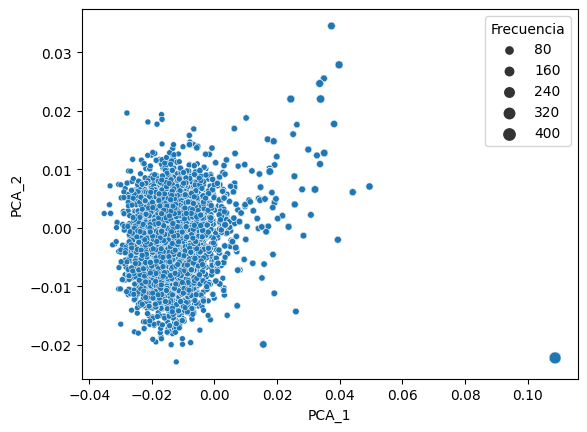

In [36]:
sns.scatterplot(data=df_PCA, x='PCA_1', y='PCA_2', size='Frecuencia')

In [37]:
top_cinco = [i[0] for i in frequency.most_common(5)]

In [38]:
palabras = []+top_cinco
for word in top_cinco:
    for relacion in cosine_distance(model, word, words_ecopetrol, 10):
        if relacion[0] not in palabras:
            palabras.append(relacion[0])

In [39]:
df_top_5_PCA = pd.DataFrame(palabras, columns=["Palabras"])
df_top_5_PCA['Frecuencia'] = df_top_5_PCA['Palabras'].apply(lambda x: frequency[x])
vector_palabras = np.array([model.wv[w] for w in palabras])
df_top_5_PCA[['PCA_1', 'PCA_2']] = PCA(random_state=0).fit_transform(vector_palabras)[:, :2]


<AxesSubplot: xlabel='PCA_1', ylabel='PCA_2'>

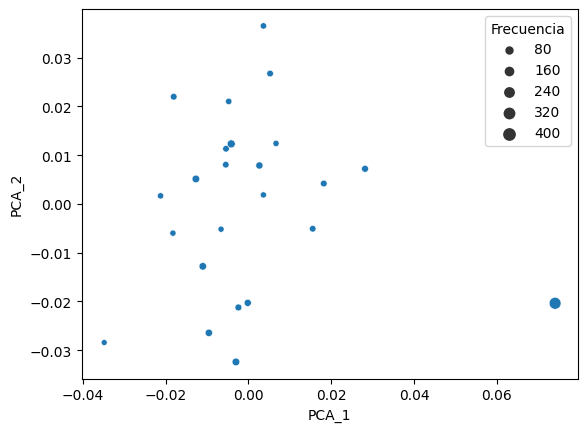

In [40]:
sns.scatterplot(data=df_top_5_PCA, x='PCA_1', y='PCA_2', size='Frecuencia')

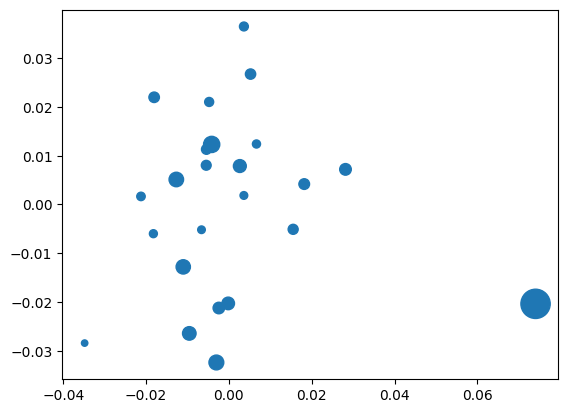

In [41]:
plt.scatter(x=df_top_5_PCA['PCA_1'], y=df_top_5_PCA['PCA_2'], s=df_top_5_PCA['Frecuencia'])

In [42]:
import plotly.express as px
import plotly.graph_objects as go

In [43]:
df_top_5_PCA['Top'] = df_top_5_PCA['Palabras'].apply(lambda x: x in top_cinco)

In [44]:
fig = px.scatter(df_top_5_PCA, x='PCA_1', y='PCA_2', hover_name='Palabras', size='Frecuencia', size_max=45, 
                 color='Top', template='plotly_white', title='Bigram similarity and frequency')
fig.show()

In [45]:
from sklearn.manifold import TSNE

In [46]:
vector_palabras = np.array([model.wv[w] for w in words_ecopetrol])
df_TSNE = pd.DataFrame(words_ecopetrol, columns=['Palabras'])
df_TSNE['Frecuencia'] = df_TSNE['Palabras'].apply(lambda x: frequency[x])
df_TSNE[['TSNE_1', 'TSNE_2']] = TSNE(n_components = 2, random_state=0).fit_transform(vector_palabras)[:, :2]

<AxesSubplot: xlabel='TSNE_1', ylabel='TSNE_2'>

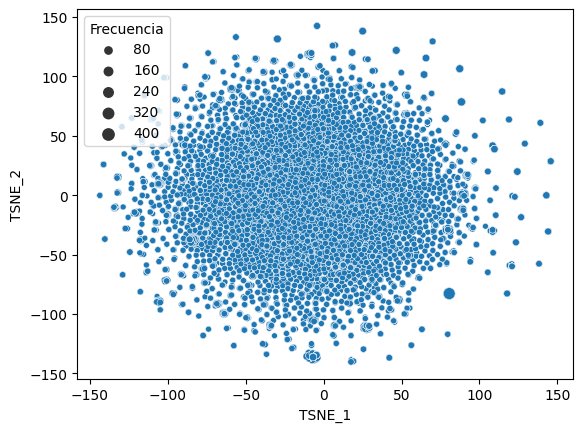

In [47]:
sns.scatterplot(data=df_TSNE, x='TSNE_1', y='TSNE_2', size='Frecuencia')

In [48]:
df_top_5_TSNE = pd.DataFrame(palabras, columns=["Palabras"])
df_top_5_TSNE['Frecuencia'] = df_top_5_TSNE['Palabras'].apply(lambda x: frequency[x])
vector_palabras = np.array([model.wv[w] for w in palabras])
df_top_5_TSNE[['PCA_1', 'PCA_2']] = TSNE(n_components = 2, random_state=0).fit_transform(vector_palabras)[:, :2]

ValueError: perplexity must be less than n_samples

In [ ]:
fig = px.scatter(df_top_5_TSNE, x='TSNE_1', y='TSNE_2', hover_name='Palabras', size='Frecuencia', size_max=45, 
                 color='Top', template='plotly_white', title='Bigram similarity and frequency')
fig.show()

In [ ]:
cont = r"#AtenciÃ³n | Ecopetrol informa que la Junta Directiva elegida en Asamblea Extraordinaria de Accionistas del 24 de octubre de 2022, en su sesiÃ³n del 27 de octubre de 2022, designÃ³ a Carlos Gustavo Cano Sanz como Presidente de la Junta Directiva ... (sigue) ???? pic.twitter.com/44naebCExGâ€” Ecopetrol (@ECOPETROL_SA) October 27, 2022"
aux = pd.read_csv("../data/raw/database.csv")

In [ ]:
cont.split()

['#AtenciÃ³n',
 '|',
 'Ecopetrol',
 'informa',
 'que',
 'la',
 'Junta',
 'Directiva',
 'elegida',
 'en',
 'Asamblea',
 'Extraordinaria',
 'de',
 'Accionistas',
 'del',
 '24',
 'de',
 'octubre',
 'de',
 '2022,',
 'en',
 'su',
 'sesiÃ³n',
 'del',
 '27',
 'de',
 'octubre',
 'de',
 '2022,',
 'designÃ³',
 'a',
 'Carlos',
 'Gustavo',
 'Cano',
 'Sanz',
 'como',
 'Presidente',
 'de',
 'la',
 'Junta',
 'Directiva',
 '...',
 '(sigue)',
 '????',
 'pic.twitter.com/44naebCExGâ€”',
 'Ecopetrol',
 '(@ECOPETROL_SA)',
 'October',
 '27,',
 '2022']

In [ ]:
ensayo = df.loc[113, 'Contenido']

In [ ]:
ensayo.rsplit('El periodismo independiente')

['           La negociaciÃ³n de la convenciÃ³n colectiva tardÃ³ exactamente 40 dÃ\xadas. Las dos partes ganaron en el acuerdo. DespuÃ©s de un fin de semana intenso en el que negociadores de Ecopetrol se enclaustraron en el hotel Cosmos 100 en BogotÃ¡ para terminar de negociar la convenciÃ³n colectiva de trabajo, el lunes en la madrugada finalmente hubo humo blanco. Lo hicieron gracias a que  el acuerdo le permite reclamar triunfos tanto a la empresa como a los sindicatos. Como lo contamos en La Silla, uno de los puntos claves de la negociaciÃ³n era que los sindicatos buscaban obtener mejoras para los contratistas, personas que no son empleados directos de Ecopetrol pero trabajan en proyectos de la empresa, a travÃ©s de otras compaÃ±Ã\xadas. En un comunicado la USO destacÃ³ cuatro logros en la negociaciÃ³n, que justamente muestran avances en ese frente. Ecopetrol publicarÃ¡ un â\x80\x9ccomunicado empresarialâ\x80\x9d que es un documento guÃ\xada para que sus empresas contratistas aument

In [ ]:
"Hola".rsplit('.')

['Hola']

# Temas
https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import nltk
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from tqdm import tqdm
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()#

In [2]:
df = pd.read_csv('../data/curated/curated_database.csv', encoding='utf-8-sig', index_col=[0])

In [3]:
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
es = spacy.load('es_core_news_md')
columna = 'Contenido'

# Convertir a objeto spaCy
aux = df[columna].str.lower()
aux = aux.apply(es)

# Tokenización
df[f'{columna} procesado'] = aux.apply(
    lambda x: [token for token in x])
# Normalización (minuscula, tamaño > 3 y solo letras)
df[f'{columna} procesado'] = df[f'{columna} procesado'].apply(
    lambda x: [token for token in x if len(token) > 3 and token.is_alpha])
# Remover stopwords (combinación de contexto y spacy).
# Convertir Token a str
with open('../NLP_Analitycs/sw_es.txt', 'r', encoding='utf-8') as file:
    stop_words_contexto = {line.split(None, 1)[0] for line in file}
es.Defaults.stop_words |= stop_words_contexto
df[f'{columna} procesado'] = df[f'{columna} procesado'].apply(
    lambda x: [token for token in x if not token.is_stop])

# Segmentación en oraciones
df[f'{columna} segmentado'] = aux.apply(
    lambda x: ", ".join([segment.orth_ for segment in x.sents]))

# Extracción de entidades
df[f'Entidades de {columna}'] = aux.apply(
    lambda x: ", ".join([ent.text for ent in x.ents]))

# Radicalización (stemming)
stemmer = nltk.SnowballStemmer('spanish')
df[f'{columna} radicalizado'] = df[f'{columna} procesado'].apply(
    lambda x: ", ".join([stemmer.stem(token.orth_) for token in x]))

# Lemmatization
df[f'{columna} lematizado'] = df[f'{columna} procesado'].apply(
    lambda x: [token.lemma_ for token in x if token.pos_ not in removal])

# Procesado a string
df[f'{columna} procesado'] = df[f'{columna} procesado'].apply(
    lambda x: ", ".join([token.orth_ for token in x]))

In [4]:
dictionary = Dictionary(df[f'{columna} lematizado'])
# Filtrar los tokens de baja y alta frecuencia. Limitar el vocabulario 
# a un máximo de 100 palabras
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=None)
# Contar el número de ocurrencias de cada palabra única
corpus = [dictionary.doc2bow(doc) for doc in df[f'{columna} lematizado']]

Modelo

100%|██████████| 19/19 [36:53<00:00, 116.49s/it]  


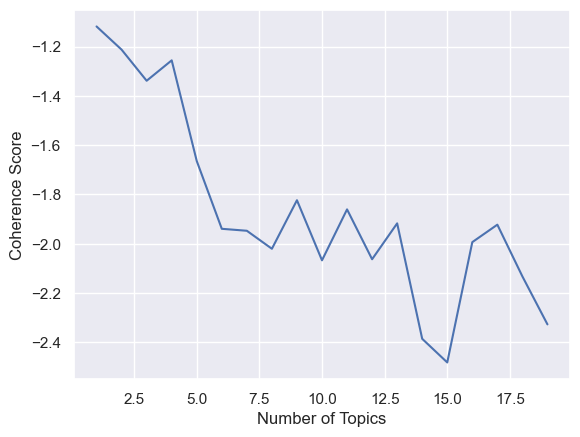

In [25]:
# Calcular la coherencia C_umass y número de topicos
topics = []
score = []
for i in tqdm(range(1,20,1)):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

100%|██████████| 19/19 [07:46<00:00, 24.54s/it]


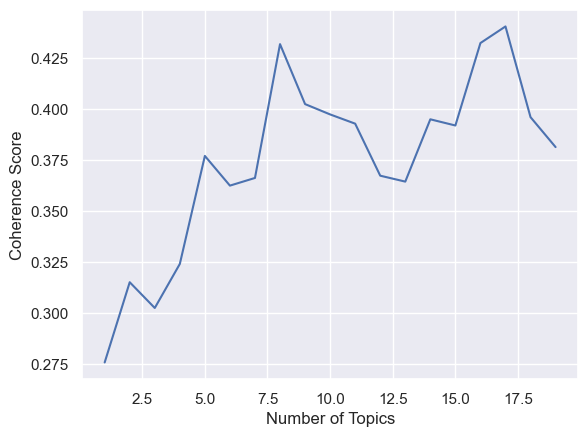

In [21]:
# Calcular la coherencia C_v y número de topicos
topics = []
score = []
for i in tqdm(range(1,20,1)):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = df[f'{columna} lematizado'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

The coherence score for C_v ranges from 0 (complete incoherence) to 1 (complete coherence). Values above 0.5 are fairly good, according to John McLevey (source: Doing Computational Social Science: A Practical Introduction By John McLevey). On the other hand, C_umass returns negative values.

In [5]:
# númeor de iteraciones 50 por defecto
# workers equivale al número de cores del computador
# passes número de veces que pasa por el corpus para entrenarse
lda_model_8 = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=8, workers=4, passes=10)
lda_model_16 = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=16, workers=4, passes=10)

In [12]:
aux = lda_model_8.print_topics(-1)

In [11]:
lda_model_16.print_topics(-1)

[(0,
  '0.021*"empresa" + 0.012*"billón" + 0.011*"precio" + 0.009*"dólar" + 0.009*"compañía" + 0.008*"ingreso" + 0.008*"contratista" + 0.008*"pesos" + 0.007*"utilidad" + 0.007*"aumento"'),
 (1,
  '0.020*"televisión" + 0.017*"petro" + 0.015*"bono" + 0.015*"caracol" + 0.014*"nacional" + 0.013*"canal" + 0.011*"exploración" + 0.010*"petróleo" + 0.010*"transmisión" + 0.008*"proceso"'),
 (2,
  '0.030*"comunidad" + 0.020*"noticia" + 0.017*"consulta" + 0.015*"previo" + 0.014*"territorio" + 0.012*"érika" + 0.012*"caracol" + 0.010*"social" + 0.010*"red" + 0.009*"enel"'),
 (3,
  '0.032*"millón" + 0.018*"medio" + 0.014*"digital" + 0.012*"agua" + 0.012*"audiencia" + 0.012*"mundial" + 0.011*"usuario" + 0.009*"persona" + 0.008*"año" + 0.008*"internet"'),
 (4,
  '0.013*"bloqueo" + 0.012*"proyecto" + 0.010*"bogotá" + 0.010*"gobierno" + 0.009*"barrancabermeja" + 0.009*"energía" + 0.009*"nacional" + 0.008*"gasolina" + 0.008*"riesgo" + 0.007*"comunidad"'),
 (5,
  '0.015*"banco" + 0.014*"estrella" + 0.013*

In [6]:
lda8_display = pyLDAvis.gensim_models.prepare(lda_model_8, corpus, dictionary)
pyLDAvis.save_html(lda8_display, 'lda8.html')
pyLDAvis.display(lda8_display)

C:\Users\andres.ospina\AppData\Roaming\Python\Python311\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [78]:
lda16_display = pyLDAvis.gensim_models.prepare(lda_model_16, corpus, dictionary)
pyLDAvis.save_html(lda16_display, 'lda16.html')
pyLDAvis.display(lda16_display)

C:\Users\andres.ospina\AppData\Roaming\Python\Python311\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [7]:
topicos = {}
for i in range(16):
    aux = lda_model_16.print_topic(i).split("+")
    aux_ = [aux[i].rsplit('*')[1][1:-2] for i in range(len(aux) - 1)]
    aux_.append(aux[len(aux) - 1].rsplit('*')[1][1:-1])
    topicos[i] = ", ".join(aux_)

In [76]:
df['Topicos'] = [topicos[sorted(lda_model_16[corpus][text])[0][0]] for text in range(len(df['Contenido']))]

### Extraer y asignar temas por clientes

In [22]:
topicos_general = {}
empresa_topicos = {}

empresas = df['Empresa'].unique()
for empresa in empresas:
    df_aux = df[df['Empresa'] == empresa].reset_index()
    
    dictionary = Dictionary(df_aux[f'{columna} lematizado'])
    dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=None)
    corpus = [dictionary.doc2bow(doc) for doc in df_aux[f'{columna} lematizado']]
    
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=8, workers=4, passes=10)
    
    topicos = {}
    for i in range(8):
        aux = lda_model.print_topic(i).split("\"")
        aux_ = [aux[i] for i in range(len(aux) - 1) if i%2 != 0]
        topicos[i] = ", ".join(aux_)
        
    df_aux['Topicos'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(df_aux['Contenido']))]
    
    topicos_general[empresa] = topicos
    empresa_topicos[empresa] = df_aux[['index', 'Topicos']]
    

In [17]:
topicos = {}
for i in range(8):
    aux = lda_model_8.print_topic(i).split("\"")
    aux_ = [aux[i] for i in range(len(aux) - 1) if i%2 != 0]
    topicos[i] = ", ".join(aux_)
topicos

{0: 'empresa, contratista, sindicato, millón, presión, llegar, trabajador, pozo, orden, año',
 1: 'energía, empresa, enel, proyecto, millón, compañía, grupo, operación, energético, negocio',
 2: 'billón, millón, precio, ingreso, empresa, acción, compañía, venta, pesos, energía',
 3: 'bolsa, acción, grupo, año, valor, seguir, mundo, dólar, resultado, pasar',
 4: 'bloqueo, gasolina, barril, combustible, barrancabermeja, producción, puerto, empresa, petróleo, nacional',
 5: 'banco, entidad, tarjeta, servicio, persona, crédito, diciembre, millón, bancolombia, digital',
 6: 'presidente, gobierno, bayón, petro, petróleo, compañía, junta, felipe, energético, empresa',
 7: 'gobierno, proceso, presidente, petro, guatemala, diálogo, cese, nacional, caso, tema'}